# **Step1_AI 강사 Agent v1.0**

## **0. 미션**

### 미션① : AI 강의 영상 제작 단계별 구축하기
* State 정의
* 1page ppt 파일 인식  텍스트, 표, 그림 저장
* 정보 분석 : 텍스트, 표, 그림 등 정보로 부터 내용 정리(LLM)
* 설명 흐름 정리 및 설명문 생성(LLM)




### 미션② : AI 강의 영상 제작 전체 흐름 엮어내기
* 설명문을 음성으로 변환(TTS)
* 음성과 슬라이드 스냅샷 이미지 합성하여 영상 제작하기
* 전체를 Agent 그래프로 엮기


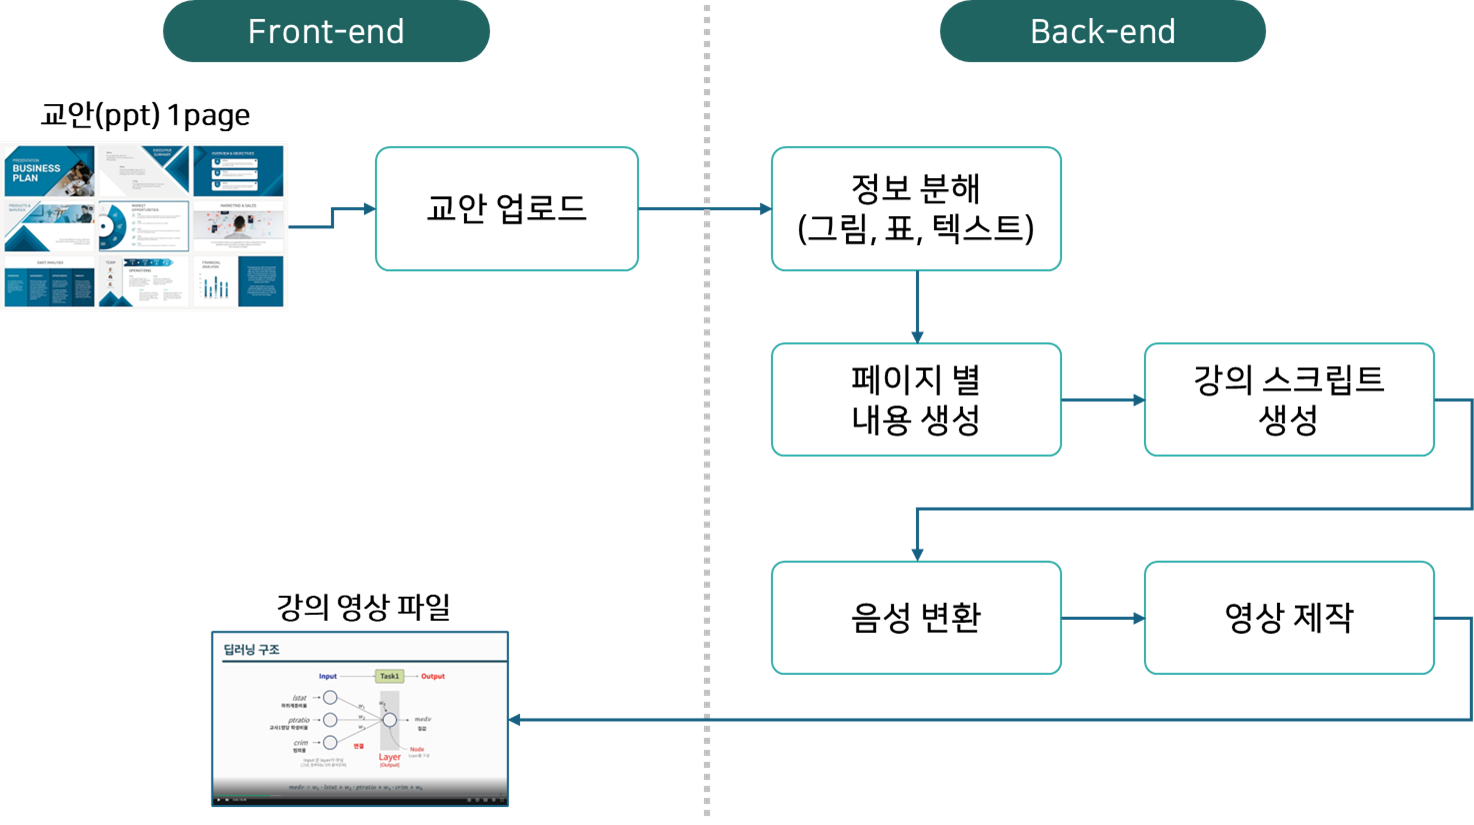

## **1. 환경준비**

### (1) 구글 드라이브

* 구글 드라이브 폴더 생성
    * 새 폴더(project_multi_modal)를 생성하고
    * 제공 받은 파일을 업로드

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (2) 한글 폰트 준비
* 한글 폰트 설치 및 설정 코드
* 영상 제작 등 한글 사용시 필요

In [2]:
!apt-get -y install ffmpeg libreoffice poppler-utils poppler-data locales \
                   fonts-noto-cjk fonts-noto-cjk-extra fonts-nanum fonts-unfonts-core
!sed -i 's/^# *ko_KR.UTF-8 UTF-8/ko_KR.UTF-8 UTF-8/' /etc/locale.gen
!locale-gen ko_KR.UTF-8
!update-locale LANG=ko_KR.UTF-8
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
fonts-noto-cjk-extra is already the newest version (1:20220127+repack1-1).
poppler-data is already the newest version (0.4.11-1).
fonts-nanum is already the newest version (20200506-1).
fonts-unfonts-core is already the newest version (1:1.0.2-080608-16).
locales is already the newest version (2.35-0ubuntu3.11).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libreoffice is already the newest version (1:7.3.7-0ubuntu0.22.04.10).
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Generating locales (this might take a while)...
  ko_KR.UTF-8... done
Generation complete.
/usr/share/fonts: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching,

In [3]:
%%bash
mkdir -p ~/.config/fontconfig
cat > ~/.config/fontconfig/fonts.conf <<'EOF'
<?xml version="1.0"?>
<!DOCTYPE fontconfig SYSTEM "fonts.dtd">
<fontconfig>

  <!-- ▷ 한국어 텍스트엔 Noto Sans CJK KR을 우선 사용 -->
  <match target="pattern">
    <test name="lang" compare="eq"><string>ko</string></test>
    <edit name="family" mode="prepend" binding="strong">
      <string>Noto Sans CJK KR</string>
    </edit>
  </match>

  <!-- ▷ 일반 가족명에도 기본 대체 추가 -->
  <alias><family>sans-serif</family><prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>serif</family><prefer><family>Noto Serif CJK KR</family></prefer></alias>
  <alias><family>monospace</family><prefer><family>Noto Sans Mono CJK KR</family></prefer></alias>

  <!-- ▷ Windows/macOS/웹에서 흔한 한글 폰트들을 Noto로 매핑 -->
  <alias><family>Malgun Gothic</family>        <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>맑은 고딕</family>             <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Apple SD Gothic Neo</family>  <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>AppleGothic</family>          <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Pretendard</family>           <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Pretendard Variable</family>  <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>NanumSquare</family>          <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Spoqa Han Sans</family>       <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>KoPub</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Gulim</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Dotum</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Batang</family>               <prefer><family>Noto Serif CJK KR</family></prefer></alias>
</fontconfig>
EOF
fc-cache -fv


/usr/share/fonts: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype/linux-libertine: caching, new cache contents: 13 fonts, 0 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 80 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 11 dirs
/usr/share/fonts/truetype/crosextra: caching, new cache contents: 8 fonts, 0 dirs
/usr/sh

### (3) 라이브러리

* 필요한 라이브러리 설치

In [4]:
!apt-get -y install ffmpeg libreoffice poppler-utils
!pip install python-pptx pillow langgraph -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libreoffice is already the newest version (1:7.3.7-0ubuntu0.22.04.10).
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


* 라이브러리 로딩

In [1]:
import os, re, textwrap, subprocess, json, base64, mimetypes, shlex
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Optional, TypedDict
from PIL import Image, ImageDraw
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE
from openai import OpenAI
from google.colab import files
from IPython.display import Audio, display, Video

### (4) OpenAI API Key 확인
* 구글드라이브에 생성한 폴더 'project_multi_modal'에서
* api_key.txt 파일 안에 각자 발급 받은 openai api key를 저장합니다.

In [2]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/Aivle/미니프로젝트/3차/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [ ]:
print(os.environ['OPENAI_API_KEY'][:30])

### (5) 유용한 함수들 제공
* 다음은 프로젝트를 수행하는데 유용한 함수들입니다.
* 이 함수들의 내용을 확인하고 필요시 활용하여 개인 과제를 수행합니다.(꼭 활용해야 하는 것은 아닙니다.)

* 공백 제거 함수

In [4]:
def clean_text(s):
    return re.sub(r"\s+", " ", s).strip()

In [9]:
# 사용 예
raw_text = " 딥러닝    모델 \n\n 학습에는 \t 많은   데이터가 필요합니다.  "
print("* 원본:", raw_text)
print("* 정제 후:", clean_text(raw_text))

* 원본:  딥러닝    모델 

 학습에는 	 많은   데이터가 필요합니다.  
* 정제 후: 딥러닝 모델 학습에는 많은 데이터가 필요합니다.


* 긴 문자열을 문장 단위로 나누는 문장 분리기

In [5]:
def split_sents(t: str) -> List[str]:
    parts = re.split(r'([\.?!])', t)
    merged = []
    for i in range(0, len(parts)-1, 2):
        sent = (parts[i] + parts[i+1]).strip()
        if sent: merged.append(sent)
    if len(parts) % 2 == 1 and parts[-1].strip():
        merged.append(parts[-1].strip())
    return [s for s in merged if s]

In [11]:
# 사용 예
text = "안녕하세요. 오늘은 날씨가 좋네요! 점심 드셨어요?"
print(split_sents(text))

['안녕하세요.', '오늘은 날씨가 좋네요!', '점심 드셨어요?']


* 오디오 길이 계산

In [6]:
def ffprobe_duration(path: str) -> float:
    out = subprocess.check_output([
        "ffprobe","-v","error","-show_entries","format=duration",
        "-of","default=noprint_wrappers=1:nokey=1", path]).decode().strip()
    return float(out)

In [ ]:
# 사용 예
uploaded = files.upload()   # 로컬 PC에서 '스티브 잡스4.mp3' 선택

mp3_file = "스티브 잡스4.mp3"
duration = ffprobe_duration(mp3_file)
print(f"{mp3_file} 길이: {duration:.2f}초")

* 이미지를 base64로 변환

In [7]:
def img_to_data_url(path: str) -> str:
    mime = mimetypes.guess_type(path)[0] or "image/png"
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime};base64,{b64}"

In [ ]:
# 사용 예
uploaded = files.upload()   # 로컬 PC에서 'cat_bird.jpg' 선택

png_path = "cat_bird.jpg"
data_url = img_to_data_url(png_path)
print(data_url[:100] + "...")   # 앞부분만 출력 (너무 길기 때문)

* 배경 이미지와 오디오 합쳐서 MP4 영상 만들기

In [8]:
def render_mp4(image_path: str, audio_path: str, out_mp4: str,
               width=1920, height=1080, ):

    dur = ffprobe_duration(audio_path)

    vf = (f"scale={width}:{height}:force_original_aspect_ratio=decrease,"
          f"pad={width}:{height}:(ow-iw)/2:(oh-ih)/2:color=black"  )

    # FFmpeg 명령
    cmd = ["ffmpeg", "-y",
            "-loop", "1", "-i", image_path,   # 정지 이미지 입력
            "-i", audio_path,                 # 오디오 입력
            "-t", str(dur),                   # 길이 = 오디오 길이
            "-vf", vf,                        # 비디오 필터
            "-c:v", "libx264", "-preset", "veryfast", "-crf", "20",
            "-c:a", "aac", "-b:a", "192k",
            "-pix_fmt", "yuv420p",
            "-movflags", "+faststart",        # 웹/브라우저 재생 친화
            out_mp4]
    subprocess.check_call(cmd)  # 외부 프로그램(FFmpeg)을 파이썬 프로세스에서 실행하고, 성공했는지 확인

In [ ]:
# 사용 예
# 이미 업로드한 cat_bird.jpg, 스티브 잡스4.mp3 를 합성

# 예시 파일 준비
image_path = "cat_bird.jpg"          # PPT 슬라이드 캡처
audio_path = "스티브 잡스4.mp3"      # 해당 슬라이드 설명 음성
output_path = "video.mp4" # 합성 결과

# 함수 실행
render_mp4(image_path, audio_path, output_path)

# 영상 확인
with open(output_path, "rb") as f:
    data = f.read()

display(Video(data=data, embed=True, mimetype="video/mp4", width=960))

## **2. 미션① : AI 강의 영상 제작 단계별 구축하기**

* State 정의
* 1page ppt 파일 인식  텍스트, 표, 그림 저장
* 정보 분석 : 텍스트, 표, 그림 등 정보로 부터 내용 정리(LLM)
* 설명 흐름 정리 및 설명문 생성(LLM)

### (1) 파일 입력

* ppt, image 업로드 코드 제공
    * sample1.pptx 와 sample1.png 제공



In [ ]:
# 파일 업로드 (sample1.pptx)
uploaded = files.upload()
pptx_path = list(uploaded.keys())[0]

In [ ]:
# 파일 업로드 (sample1.png)
uploaded = files.upload()
slide_image_path = list(uploaded.keys())[0]

In [ ]:
# 사용자 프롬프트
USER_PROMPT = {
    "voice": "alloy",
    "tone": "친절하고 명료한 강의 톤",
    "style": "예시와 핵심 요점 중심"
}
# 출력 dir 만들기
WORK_DIR = "./step1_output"
MEDIA_DIR = "./step1_output/media"
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MEDIA_DIR, exist_ok=True)

### (2) State 선언

* 각 노드의 입출력 관리를 위한 State 구성
    * 각 함수(노드)에서 채워가며 관리해야 할 정보를 도출
    * 이를 하나의 State로 정의


In [9]:
# State 정의 및 초기화
class State(TypedDict, total=False): # total=False는 TypedDict에서 모든 키를 선택(optional)으로 취급
    # 입력/기본
    pptx_path: str
    work_dir: str
    prompt: Dict
    slide_index: int
    # 추출 산출물
    texts: List[str]
    tables: List[List[List[str]]]
    images: List[str]
    slide_image: List[str]
    # 생성 산출물
    page_content: str
    script: str
    # 미디어 산출물
    audio: str
    video_path: str


### (3) 정보 분해
* 목적 : 첫 번째 슬라이드에서 텍스트, 표, 이미지를 추출하여 state에 저장
* 입/출력
    * 입력: state["pptx_path"] (PPTX 경로), slide_index (현재는 무시, 0고정)
    * 출력 : state["texts"], state["tables"], state["images"] 갱신
* 처리
    * 슬라이드의 각 shape 탐색
    * 텍스트 → 문단 단위 추출 후 clean_text로 정제
    * 표 → 2차원 리스트로 변환 후 저장
    * 이미지 → 파일로 저장하고 경로를 기록

* 노드 함수 생성

In [10]:
def node_parse_ppt(state: State) -> State:
    ppt = Presentation(state['pptx_path'])
    slide_idx = state.get("slide_idx", 0)
    work_dir = state.get("work_dir", "./")
    texts = state.get("texts", [])
    tables = state.get("tables", [])
    images = state.get("images", [])


    sd0 = ppt.slides[slide_idx]
    # 각 객체 종류 확인
    for i, sh in enumerate(sd0.shapes) :
        if sh.has_text_frame :
            print(f'[{i}] text')
            txt = "\n".join(p.text for p in sh.text_frame.paragraphs)
            texts.append(txt)
        if sh.shape_type == MSO_SHAPE_TYPE.TABLE :
            print(f'[{i}] table')
            tbl = [[clean_text(c.text) for c in r.cells] for r in sh.table.rows]
            tables.append(tbl)
        if sh.shape_type == MSO_SHAPE_TYPE.PICTURE :
            print(f'[{i}] image')
            ext = sh.image.ext              # 이미지의 원본 확장자를 얻는다(예: png, jpg).
            path = os.path.join(work_dir, "media", f"slide1_img_0.{ext}")
            images.append(path)
            with open(path, "wb") as f: f.write(sh.image.blob)         # 파일 저장
    state['texts'] = texts
    state['tables'] = tables
    state['images'] = images
    return state

* 노드 테스트

In [ ]:
initial_state: State = {
    # 입력/기본
    'pptx_path': '/content/sample1.pptx',
    'work_dir': './step1_output/',
    'slide_index': 0,

}

initial_state = node_parse_ppt(initial_state)

In [ ]:
print(initial_state["texts"] ,initial_state["tables"], initial_state["images"])

### (4) 내용 생성

* 목적 : 추출된 텍스트·표·이미지를 기반으로 LLM을 호출해 페이지 요약 문단을 생성
* 입/출력
    * 입력: state["texts"], state["tables"], state["images"], state["slide_image"], state["prompt"]
    * 출력: state["page_content"] (LLM 생성 결과 요약 문단)
* 처리
    * 표는 첫 번째 표의 앞 6행만 문자열로 변환
    * 이미지(최대 3개)를 data URL로 인코딩해 멀티모달 입력에 포함
    * 프롬프트 규칙(과장 금지, 4~6문장, 불릿 금지, 스타일 적용, 이미지 설명 포함) 적용
    * LLM 호출 결과를 page_content에 저장

* 노드 함수 생성

In [11]:
LLM_MODEL = "gpt-4o-mini"
TTS_MODEL = "gpt-4o-mini-tts"
client = OpenAI()

In [12]:
def node_generate_text(state: dict) -> dict:
    """
    내용 생성
    - 텍스트, 표, 이미지 정보를 기반으로 LLM을 호출해 페이지 요약 생성
    """

    # (1) 입력 불러오기
    texts_raw = state.get("texts", [])
    if isinstance(texts_raw, list):
        texts = clean_text(" ".join(map(str, texts_raw)))
    else:
        texts = clean_text(str(texts_raw))

    tables = state.get("tables", [])
    images = state.get("images", [])
    slide_image = state.get("slide_image", "")
    prompt = clean_text(str(state.get("prompt", "")))

    # (2) 표 전처리: 첫 번째 표의 앞 6행만 문자열로 변환
    table_text = ""
    if tables:
        first_table = tables[0][:6]
        table_text = "\n".join([" | ".join(map(str, row)) for row in first_table])

    # (3) 이미지 인코딩 (최대 3개)
    image_data_urls = []
    for img_path in images[:3]:
        try:
            image_data_urls.append(img_to_data_url(img_path))
        except Exception:
            continue  # 잘못된 경로나 손상된 파일은 무시

    # (4) LLM 입력 텍스트 구성
    content_input = (
        f"다음은 슬라이드의 주요 정보입니다.\n"
        f"---\n"
        f"[텍스트]\n{texts}\n\n"
        f"[표 (앞 6행)]\n{table_text}\n\n"
        f"[프롬프트 지침]\n{prompt}\n"
        f"---\n"
        f"규칙:\n"
        f"- 과장 금지, 객관적으로 요약\n"
        f"- 4~6문장으로 작성\n"
        f"- 불릿포인트 사용 금지\n"
        f"- 글머리표 없이 자연스러운 문단 형태\n"
        f"- 이미지 설명을 내용에 자연스럽게 통합\n"
    )

    # (5) 멀티모달 메시지 구성
    messages = [
        {"role": "system", "content": "당신은 슬라이드 내용을 요약하는 전문 요약가입니다."},
        {"role": "user", "content": [{"type": "text", "text": content_input}]}
    ]

    for img_url in image_data_urls:
        messages[-1]["content"].append({
            "type": "image_url",
            "image_url": {"url": img_url}
        })


    # (6) LLM 호출
    response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=messages
    )

    # (7) 결과 정리 및 저장
    page_content = clean_text(response.choices[0].message.content)
    state["page_content"] = " ".join(split_sents(page_content))

    return state


* 노드 테스트

In [ ]:
initial_state = node_generate_text(initial_state)
initial_state['page_content']

### (5) 강의 스크립트 생성

* 목적 : 슬라이드 요약(page_content)을 기반으로 60~90초 분량의 발표 대본(스크립트)을 작성하고 저장
* 입/출력
    * 입력:
        * state["page_content"] (슬라이드 핵심 요약 문단)
        * state["prompt"] (tone 키 사용 → 말투 지시)
        * state["work_dir"] (스크립트 저장 디렉토리)
    * 출력:
        * state["script"] (생성된 발표 스크립트)
        * script.txt 파일 (work_dir 내 저장)
* 처리
    * LLM에 시스템 프롬프트(발표 대본 작성 보조 에이전트)와 사용자 요청(인트로→설명→마무리 구조, 말투, 금지 규칙)을 전달
    * LLM 응답을 문자열로 정리해 state["script"]에 저장
    * 동시에 script.txt로 파일 저장

* 노드 함수 생성

In [13]:
def node_generate_script(state: dict) -> dict:
    """
    강의 스크립트 생성
    - 슬라이드 요약(page_content)을 기반으로 60~90초 분량의 발표 대본을 작성하고 저장
    """

    # (1) 입력 불러오기
    page_content = state.get("page_content", "")
    prompt = state.get("prompt", {}) or {}
    tone = prompt.get("tone", "전문적이고 신뢰감을 주는 톤")
    style = prompt.get("style", "쉬운 이해 중심")
    work_dir = state.get("work_dir", "./")

    # (2) 시스템 및 사용자 프롬프트 구성
    system_prompt = (
        "당신은 슬라이드 내용을 기반으로 발표 대본을 작성하는 전문 발표 코치입니다.\n"
        "대본은 약 60~90초 분량으로, 자연스럽고 명확한 흐름(인트로 → 설명 → 마무리)을 갖추어야 합니다.\n"
        "청중에게 직접 말하듯이 자연스럽고, 불필요한 반복이나 과장은 피해야 합니다.\n"
        "항상 명확하고 듣기 좋은 문장 구조를 사용하세요."
    )

    user_prompt = (
        f"다음 슬라이드 요약을 바탕으로 발표 스크립트를 작성하세요.\n\n"
        f"---\n"
        f"[요약 내용]\n{page_content}\n"
        f"---\n"
        f"규칙:\n"
        f"- 인트로(주제 소개), 본문(핵심 설명), 마무리(정리 및 메시지) 구조로 구성\n"
        f"- {tone}으로 말하세요.\n"
        f"- {style}으로 말하세요.\n"
        f"- 분량은 60~90초에 해당하는 자연스러운 길이로 작성\n"
        f"- 글머리표나 번호 매기기 금지, 한 단락으로 자연스럽게 이어질 것\n"
    )

    # (3) LLM 호출
    response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )

    script = response.choices[0].message.content.strip()
    state["script"] = script

    # (4) 파일 저장
    os.makedirs(work_dir, exist_ok=True)
    script_path = os.path.join(work_dir, "script.txt")
    with open(script_path, "w", encoding="utf-8") as f:
        f.write(script)

    return state


* 테스트

In [ ]:
initial_state = node_generate_script(initial_state)
initial_state['script']

## **3. 미션② : AI 강의 영상 제작 전체 흐름 엮어내기**

* 설명문을 음성으로 변환(TTS)
* 음성과 슬라이드 스냅샷 이미지 합성하여 영상 제작하기
* 전체를 Agent 그래프로 엮기

### (1) 음성 변환

* 목적 : 발표 스크립트(script)를 TTS 모델을 이용해 음성(mp3) 파일로 변환하고 state에 저장
* 입/출력
    * 입력:
        * state["script"] (발표 대본 텍스트)
        * state["prompt"]["voice"] (선택적, 목소리 프리셋. 기본값 "alloy")
        * state["work_dir"] (오디오 저장 위치)
    * 출력:
        * state["audio"] (생성된 mp3 파일 경로)
        * 콘솔 출력: MP3 길이(sec)
* 처리
    * OpenAI TTS 모델(TTS_MODEL)에 스크립트와 목소리 옵션 전달
    * 응답 받은 음성 데이터를 narration.mp3 파일로 저장
    * ffprobe_duration()으로 생성된 MP3 길이 확인 후 콘솔에 출력
    * state["audio"]에 파일 경로 기록

* 노드 함수 생성

In [14]:
def node_tts(state: dict) -> dict:
    """
    발표 스크립트를 음성(mp3)으로 변환하고 state에 저장
    입력:
        state["script"] - 발표 대본 텍스트
        state["prompt"]["voice"] - 선택적, 목소리 프리셋 (기본 'alloy')
        state["work_dir"] - 저장 디렉토리
    출력:
        state["audio"] - mp3 파일 경로
        콘솔 출력 - mp3 길이(sec)
    """

    # (1) 입력 불러오기
    script = state.get("script", "")
    prompt = state.get("prompt", {}) or {}
    voice = prompt.get("voice", "alloy")
    work_dir = state.get("work_dir", "./")

    if not script.strip():
        raise ValueError("state['script']가 비어 있습니다. 먼저 대본을 생성하세요.")

    # (2) 저장 경로 준비
    os.makedirs(work_dir, exist_ok=True)
    audio_path = os.path.join(work_dir, "narration.mp3")

    # (3) OpenAI TTS 호출
    response = client.audio.speech.create(
        model=TTS_MODEL,
        voice=voice,
        input=script,
        response_format="mp3"
    )

    # (4) 파일 저장
    with open(audio_path, "wb") as f:
        f.write(response.read())

    # (5) ffprobe_duration() 활용해 길이 출력
    duration = ffprobe_duration(audio_path)
    print(f"[TTS] 생성된 MP3 길이: {round(duration, 1)}초")

    # (6) state에 경로 저장
    state["audio"] = audio_path

    return state

* 노드 테스트

In [ ]:
initial_state = node_tts(initial_state)

In [ ]:
# 오디오 play 예시 코드
from IPython.display import Audio, display
audio_path = initial_state["audio"]
display(Audio(filename=audio_path))
print("Audio file:", audio_path)

### (2) 영상 제작
* 목적 : 슬라이드 이미지와 음성을 합쳐 mp4 영상 생성
* 입/출력
    * 입력: state["slide_image"][0], state["audio"], state["work_dir"], state["slide_index"]
    * 출력: state["video_path"] (생성된 mp4 경로)
* 처리
    * 첫 번째 슬라이드 이미지를 배경으로 선택
    * 오디오(mp3)와 함께 render_mp4() 호출
    * 결과 영상을 slideN_lecture.mp4로 저장 후 경로 기록

* 노드 함수 생성

In [15]:
def node_make_video(state: dict) -> dict:
    """
    영상 제작
    - 슬라이드 이미지와 음성을 합쳐 mp4 영상 생성
    입력:
        state["slide_image"][0] : 첫 번째 슬라이드 이미지 경로
        state["audio"] : mp3 오디오 경로
        state["work_dir"] : 저장 디렉토리
        state["slide_index"] : 슬라이드 번호
    출력:
        state["video_path"] : 생성된 mp4 경로
    """

    # (1) 입력 불러오기
    slide_imgs = state.get("slide_image", [])
    audio_path = state.get("audio", "")
    work_dir = state.get("work_dir", "./")
    slide_index = state.get("slide_index", 0)

    if not slide_imgs or not os.path.exists(slide_imgs[0]):
        raise FileNotFoundError("슬라이드 이미지 파일을 찾을 수 없습니다.")
    if not os.path.exists(audio_path):
        raise FileNotFoundError("오디오 파일을 찾을 수 없습니다.")

    # (2) 출력 경로 설정
    os.makedirs(work_dir, exist_ok=True)
    video_filename = f"slide{slide_index}_lecture.mp4"
    out_mp4 = os.path.join(work_dir, video_filename)

    # (3) render_mp4() 호출
    render_mp4(
        image_path=slide_imgs[0],
        audio_path=audio_path,
        out_mp4=out_mp4
    )

    # (4) 결과 기록
    state["video_path"] = out_mp4
    return state


* 노드 테스트

In [ ]:
initial_state = node_make_video(initial_state)

In [ ]:
# 동영상 play 예시 코드
video_path = initial_state["video_path"]

with open(video_path, "rb") as f:
    data = f.read()

display(Video(data=data, embed=True, mimetype="video/mp4", width=960))

### (3) Agent 만들기 : 그래프로 엮기
* 다음 그래프를 참조하여 하나의 에이전트로 엮어 봅시다.

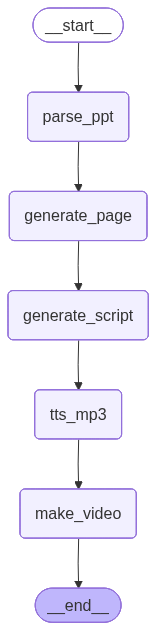

In [16]:
from langgraph.graph import StateGraph, END
builder = StateGraph(State)
builder.add_node('parse_ppt', node_parse_ppt)
builder.add_node('generate_page', node_generate_text)
builder.add_node('genrate_script', node_generate_script)
builder.add_node('tts_mp3', node_tts)
builder.add_node('make_video', node_make_video)

builder.set_entry_point('parse_ppt')
builder.add_edge('parse_ppt', 'generate_page')
builder.add_edge('generate_page', 'genrate_script')
builder.add_edge('genrate_script', 'tts_mp3')
builder.add_edge('tts_mp3', 'make_video')
builder.set_finish_point('make_video')

app = builder.compile()

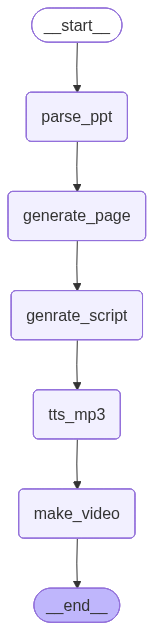

In [17]:
app

## **4. 시스템 실행**

미션1,2에서 수행한 결과를 통합 테스트 해 봅시다.

### (1) 준비 작업
* 파일 업로드
* 사용자 프롬프트 준비

In [26]:
# 파일 업로드 (1page image)
uploaded = files.upload()
pptx_path = list(uploaded.keys())[0]

Saving sample1.pptx to sample1.pptx


In [27]:
# 파일 업로드 (sample1.png)
uploaded = files.upload()
slide_image_path = list(uploaded.keys())[0]

Saving sample1.png to sample1.png


In [28]:
# 사용자 프롬프트
USER_PROMPT = {
    "voice": "fable",
    "tone": "친절하고 명료한 강의 톤",
    "style": "예시와 핵심 요점 중심"
}
# 출력 dir 만들기
WORK_DIR = "./step1_output/"
MEDIA_DIR = "./step1_output/media"
SLIDES_DIR = "./step1_output/slides"

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MEDIA_DIR, exist_ok=True)
os.makedirs(SLIDES_DIR, exist_ok=True)

### (2) Agent 실행
* State 초기화
* app 실행
* 동영상 play

In [ ]:
LLM_MODEL = "gpt-4o-mini"
TTS_MODEL = "gpt-4o-mini-tts"
client = OpenAI()

In [29]:
state:State = {
    'pptx_path': pptx_path,
    'work_dir': WORK_DIR,
    'prompt': USER_PROMPT,
    'slide_index': 0,
    'slide_image': [slide_image_path]
}

In [30]:
# 전체 그래프 실행
state = app.invoke(state)

# 영상 재생
video_path = state["video_path"]
with open(video_path, "rb") as f:
    data = f.read()

display(Video(data=data, embed=True, mimetype="video/mp4", width=960))

[0] text
[1] text
[2] text
[3] image
[4] table
[TTS] 생성된 MP3 길이: 77.7초


## **5. Gradio 익히기**

In [18]:
import gradio as gr

In [19]:
def generate_state_and_run(pptx_file, slide_images, tone, voice, style, slide_index):

    WORK_DIR = os.path.abspath("./graido_output/")
    os.makedirs(WORK_DIR, exist_ok=True)

    pptx_path = pptx_file

    media_dir = os.path.join(WORK_DIR, "media")
    os.makedirs(media_dir, exist_ok=True)

    slide_image_paths = [str(uploaded_file) for uploaded_file in slide_images]

    USER_PROMPT = {"tone": tone, "voice": voice, "style": style}

    state = {
        "pptx_path": pptx_path,
        "work_dir": WORK_DIR,
        "prompt": USER_PROMPT,
        "slide_index": int(slide_index),
        "slide_image": slide_image_paths
    }

    state = app.invoke(state)
    return state.get("video_path", "")


# =============================
# Gradio 인터페이스 구성
# =============================

tone_choices = [
    "친절하고 명료한 강의 톤",
    "열정적이고 에너지 넘치는 발표 톤",
    "차분하고 신뢰감 있는 설명 톤",
    "격식 있고 전문적인 톤"
]

voice_choices = ["alloy", "fable", "verse", "coral", "onyx"]

style_choices = [
    "예시와 핵심 요점 중심",
    "스토리텔링 중심",
    "데이터 기반 설명",
    "감정과 공감 중심"
]

demo = gr.Interface(
    fn=generate_state_and_run,
    inputs=[
        gr.File(label="🎞️ PPTX 파일 업로드", file_types=[".pptx"], type="filepath"),
        gr.Files(label="🖼️ PNG 슬라이드 이미지 업로드 (여러 개 가능)", file_types=[".png"], type="filepath"),
        gr.Radio(label="🗣️ 말투 (tone)", choices=tone_choices, value="친절하고 명료한 강의 톤"),
        gr.Radio(label="🎤 목소리 (voice)", choices=voice_choices, value="fable"),
        gr.Radio(label="🧩 스타일 (style)", choices=style_choices, value="예시와 핵심 요점 중심"),
        gr.Number(label="📄 슬라이드 인덱스 (0부터 시작)", value=0, precision=0)
    ],
    outputs=gr.Video(label="📽️ 생성된 강의 영상", format="mp4"),
    title="🎬 AI 슬라이드 강의 생성기",
    description="PPTX 파일을 업로드하고 말투, 목소리, 스타일을 선택하면 AI가 자동으로 발표 스크립트와 영상을 생성합니다.",
    theme="soft"
)


In [20]:
# 출력 dir 만들기
#demo.close()
demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://21df197235ea4ea497.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


[0] text
[1] text
[2] text
[3] image
[4] table
[TTS] 생성된 MP3 길이: 71.6초
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://21df197235ea4ea497.gradio.live


In [ ]:
# import os, signal

# # 현재 Colab 런타임 프로세스 중에서 Gradio 관련 서버가 열려 있다면 전부 종료
# !ps -ef | grep gradio
# os.kill(os.getpid(), signal.SIGKILL)
